## Источник данных
Данные для исследования были взяты с популярного ресурса для машинного обучения kaggle.com
<br>Страница с датасетом: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset

## Необходимые библиотеки

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sklearn
import xgboost as xgb
from sklearn import linear_model
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
pd.options.display.max_columns = None

## Обработка данных

In [42]:
movies = pd.read_csv('./data/movies_metadata.csv', low_memory=False)
movies

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,/jldsYflnId4tTWPx8es3uzsB1I8.jpg,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,/xZkmxsNmYXJbKVsTRLLx3pqGHx7.jpg,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,/d5bX92nDsISNhu3ZT69uHwmfCGw.jpg,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45

In [43]:
movies.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

#### Удалим ненужные столбцы

In [44]:
movies.drop('poster_path', axis='columns', inplace=True)

In [45]:
#удаляем доходы, так как мы не можем их знать при прогнозе новых фильмов
movies.drop('revenue', axis='columns', inplace=True)

In [46]:
movies.drop('video', axis='columns', inplace=True)

In [47]:
movies.drop('homepage', axis='columns', inplace=True)

In [48]:
movies.drop('overview', axis='columns', inplace=True)

In [49]:
movies.drop('imdb_id', axis='columns', inplace=True)

In [50]:
movies.drop('original_title', axis='columns', inplace=True)

In [51]:
#удаляем по той же причине, что и revenue
movies.drop('popularity', axis='columns', inplace=True)

In [52]:
movies.drop('tagline', axis='columns', inplace=True)

In [53]:
movies.drop('release_date', axis='columns', inplace=True)

Удалим фильмы, у которых отсутствует название

In [54]:
movies.dropna(subset=['title'], inplace=True)

In [55]:
#Проверим снова на пропущенные значения
movies.isnull().sum()

adult                        0
belongs_to_collection    40970
budget                       0
genres                       0
id                           0
original_language           11
production_companies         0
production_countries         0
runtime                    257
spoken_languages             0
status                      81
title                        0
vote_average                 0
vote_count                   0
dtype: int64

#### Работа с типами данных

Заменим в столбце adult булевые значения на целочисленные (0, 1)

In [56]:
movies['adult'].value_counts()

False    45451
True         9
Name: adult, dtype: int64

In [57]:
movies['adult'] = movies['adult'].apply(lambda x: 1 if eval(x) else 0)
movies['adult'].head()

0    0
1    0
2    0
3    0
4    0
Name: adult, dtype: int64

In [58]:
movies['adult'].value_counts()

0    45451
1        9
Name: adult, dtype: int64

Заменим в столбце belongs_to_collection 0 если там отсутсвует значение (т.е. фильм не входит в франшизу) и 1 если значение какое-то есть

In [59]:
movies['belongs_to_collection'].isnull().sum()

40970

In [60]:
movies['belongs_to_collection'] = movies['belongs_to_collection'].apply(lambda x: 1 if type(x) == str else 0)
movies['belongs_to_collection'].head()

0    1
1    0
2    1
3    0
4    1
Name: belongs_to_collection, dtype: int64

In [61]:
movies['belongs_to_collection'].value_counts()

0    40970
1     4490
Name: belongs_to_collection, dtype: int64

Разберёмся, какие есть жанры и какие можно отбросить из-за их малого количества

In [62]:
movies['genres'][0]

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

In [63]:
genres = {}
for i in range(movies.shape[0]):
    temp_genres = eval(f"{movies['genres'].iloc[i]}")
    for g in temp_genres:
        genres[g['name']] = genres.get(g['name'], 0) + 1

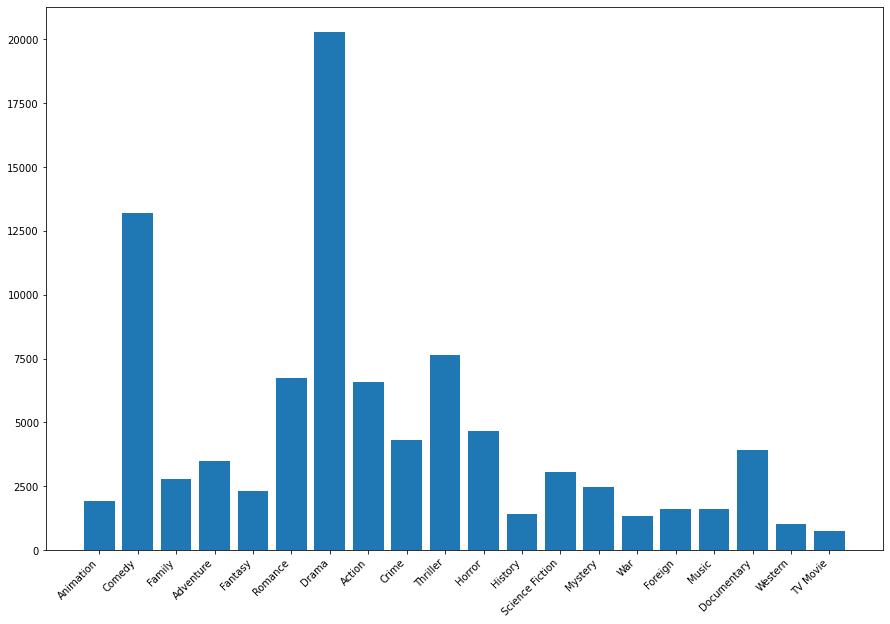

In [64]:
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(genres.keys(), genres.values())
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.show()

Минимальное количество - 766, поэтому никакие жанры удалять не будем
<br> Для каждого жанра выделим по столбцу и отметим там присутсвие этого жанра в фильме

In [65]:
for g in genres.keys():
    temp_df = movies['genres'].apply(lambda x: 1 if g in x else 0)
    movies[f'is_{g}'] = temp_df
movies = movies.copy()
movies.head()

,adult,belongs_to_collection,budget,genres,id,original_language,production_companies,production_countries,runtime,spoken_languages,status,title,vote_average,vote_count,is_Animation,is_Comedy,is_Family,is_Adventure,is_Fantasy,is_Romance,is_Drama,is_Action,is_Crime,is_Thriller,is_Horror,is_History,is_Science Fiction,is_Mystery,is_War,is_Foreign,is_Music,is_Documentary,is_Western,is_TV Movie
0,0,1,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,7.7,5415.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,6.9,2413.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,6.5,92.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,6.1,34.0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,5.7,173.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [66]:
movies.drop('genres', axis='columns', inplace=True)

Проведём анализ языков, на которох был снят фильм

In [67]:
movies['original_language'].value_counts()

en    32267
fr     2438
it     1529
ja     1349
de     1080
      ...  
ay        1
rw        1
cy        1
tg        1
si        1
Name: original_language, Length: 89, dtype: int64

Исключим языки с количеством фильмов < 100 и пропущенные значения

In [68]:
lang = movies['original_language'].value_counts()
lang = lang[lang >= 100]
movies = movies[movies['original_language'].isin(list(lang.index))].dropna(subset=['original_language'])

In [69]:
movies['original_language'].value_counts()

en    32267
fr     2438
it     1529
ja     1349
de     1080
es      994
ru      826
hi      508
ko      444
zh      409
sv      384
pt      316
cn      313
fi      297
nl      248
da      225
pl      219
tr      150
cs      130
el      113
no      106
fa      101
hu      100
Name: original_language, dtype: int64

In [70]:
movies.drop('original_language', axis='columns', inplace=True)

Разберёмся, какие есть компании и страны создатели

In [71]:
companies = {}
for i in range(movies.shape[0]):
    temp_companies = eval(f"{movies['production_companies'].iloc[i]}")
    for g in temp_companies:
        companies[g['name']] = companies.get(g['name'], 0) + 1
for c in list(companies.keys()):
    if companies[c] < 50:
        del companies[c]

Оставим только компании, у которых было больше 50 фильмов за всё время

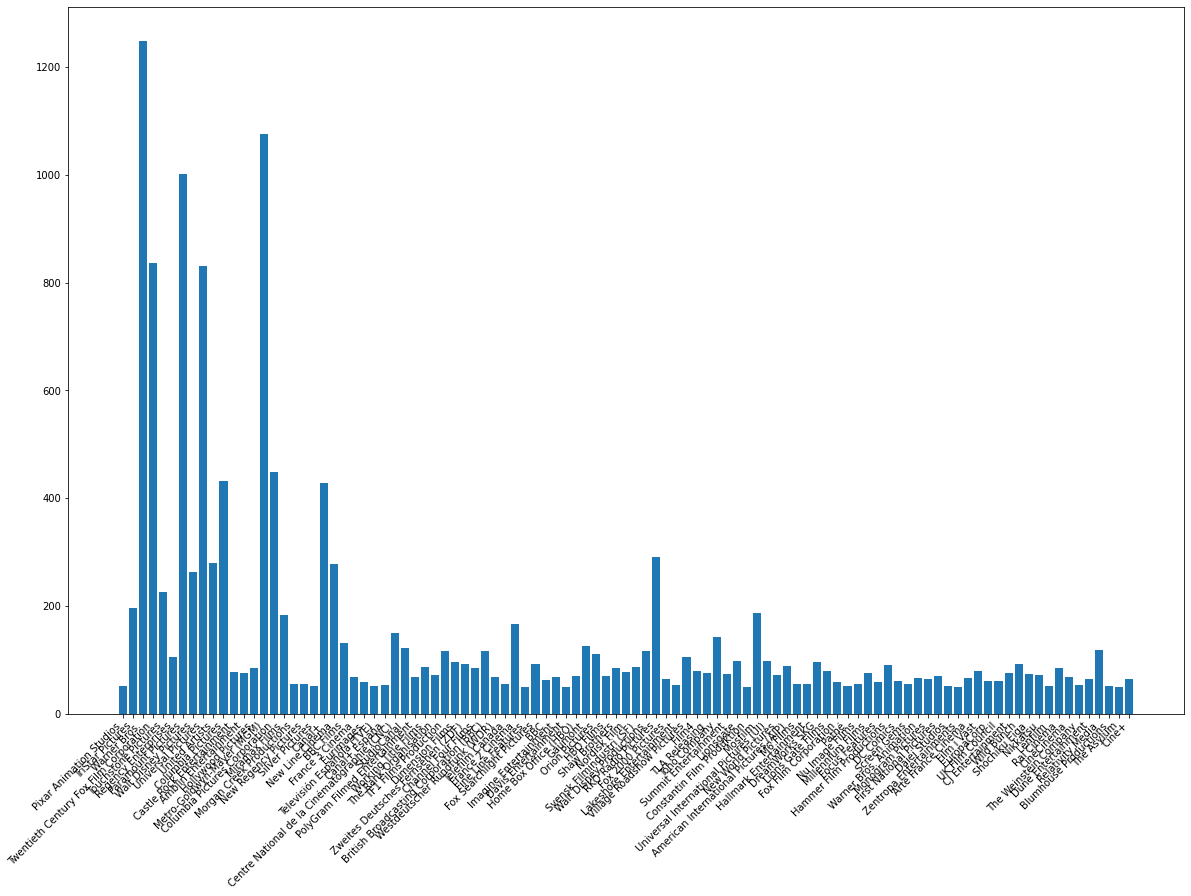

In [72]:
fig, ax = plt.subplots(figsize=(20,13))
ax.bar(companies.keys(), companies.values())
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.show()

In [73]:
for c in companies.keys():
    temp_df = movies['production_companies'].apply(lambda x: 1 if c in x else 0)
    movies[f'company_{c}'] = temp_df
    movies = movies.copy()
movies.head()

,adult,belongs_to_collection,budget,id,production_companies,production_countries,runtime,spoken_languages,status,title,vote_average,vote_count,is_Animation,is_Comedy,is_Family,is_Adventure,is_Fantasy,is_Romance,is_Drama,is_Action,is_Crime,is_Thriller,is_Horror,is_History,is_Science Fiction,is_Mystery,is_War,is_Foreign,is_Music,is_Documentary,is_Western,is_TV Movie,company_Pixar Animation Studios,company_TriStar Pictures,company_Warner Bros.,company_Twentieth Century Fox Film Corporation,company_Touchstone Pictures,company_Regency Enterprises,company_Paramount Pictures,company_Walt Disney Pictures,company_Universal Pictures,company_United Artists,company_Columbia Pictures,company_Castle Rock Entertainment,company_Amblin Entertainment,company_Hollywood Pictures,company_Metro-Goldwyn-Mayer (MGM),company_Columbia Pictures Corporation,company_Miramax Films,company_Morgan Creek Productions,company_New Regency Pictures,company_Silver Pictures,company_Canal+,company_New Line Cinema,company_BBC Films,company_France 3 Cinéma,company_Eurimages,company_Televisión Española (TVE),company_Canal+ España,company_Centre National de la Cinématographie (CNC),company_StudioCanal,company_PolyGram Filmed Entertainment,company_Working Title Films,company_The Rank Organisation,company_TF1 Films Production,company_Dimension Films,company_Zweites Deutsches Fernsehen (ZDF),company_Channel Four Films,company_British Broadcasting Corporation (BBC),company_Westdeutscher Rundfunk (WDR),company_Téléfilm Canada,company_France 2 Cinéma,company_Fine Line Features,company_Fox Searchlight Pictures,company_BBC,company_Imagine Entertainment,company_Davis Entertainment,company_Home Box Office (HBO),company_Gaumont,company_Orion Pictures,company_HBO Films,company_Shaw Brothers,company_Nordisk Film,company_Svensk Filmindustri (SF),company_Walt Disney Productions,company_RKO Radio Pictures,company_Fox 2000 Pictures,company_Lakeshore Entertainment,company_Village Roadshow Pictures,company_Film4,company_TLA Releasing,company_Toho Company,company_Summit Entertainment,company_Lionsgate,company_Constantin Film Produktion,company_Mosfilm,company_Universal International Pictures (UI),company_New World Pictures,company_American International Pictures (AIP),company_M6 Films,company_Hallmark Entertainment,company_DreamWorks SKG,company_Lions Gate Films,company_Fox Film Corporation,company_Pathé,company_Nu Image Films,company_Millennium Films,company_Focus Features,company_Hammer Film Productions,company_DC Comics,company_Screen Gems,company_Warner Bros. Animation,company_Monogram Pictures,company_First National Pictures,company_Daiei Studios,company_Zentropa Entertainments,company_Arte France Cinéma,company_Film i Väst,company_EuropaCorp,company_UK Film Council,company_CJ Entertainment,company_Wild Bunch,company_Shôchiku Eiga,company_Nikkatsu,company_Lenfilm,company_Rai Cinema,company_CinéCinéma,company_The Weinstein Company,company_Dune Entertainment,company_Relativity Media,company_Blumhouse Productions,company_The Asylum,company_Ciné+
0,0,1,30000000,862,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,7.7,5415.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,65000000,8844,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,6.9,2413.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,15602,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[

In [74]:
country = {}
for i in range(movies.shape[0]):
    temp_country = eval(f"{movies['production_countries'].iloc[i]}")
    for g in temp_country:
        country[g['name']] = country.get(g['name'], 0) + 1
for c in list(country.keys()):
    if country[c] < 15:
        del country[c]

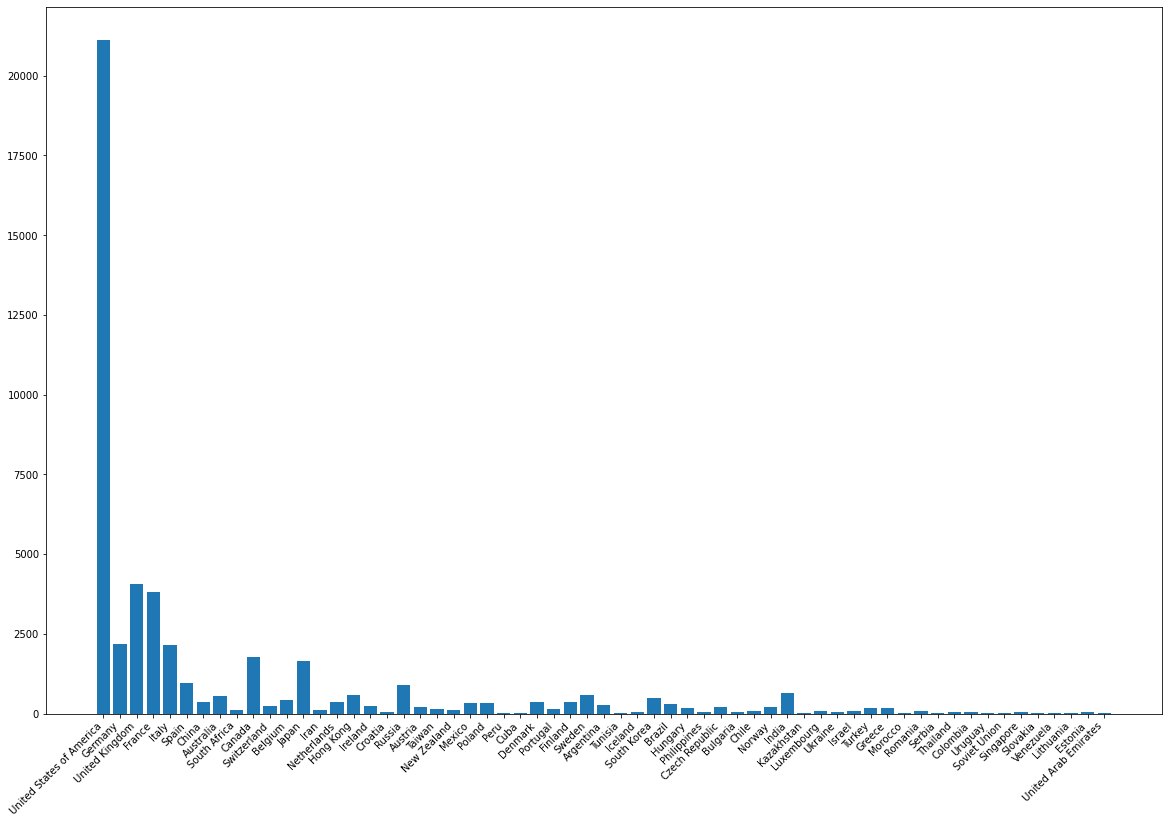

In [75]:
fig, ax = plt.subplots(figsize=(20,13))
ax.bar(country.keys(), country.values())
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.show()

In [76]:
for c in country.keys():
    temp_df = movies['production_countries'].apply(lambda x: 1 if c in x else 0)
    movies[f'country_{c}'] = temp_df
movies = movies.copy()
movies.head()

,adult,belongs_to_collection,budget,id,production_companies,production_countries,runtime,spoken_languages,status,title,vote_average,vote_count,is_Animation,is_Comedy,is_Family,is_Adventure,is_Fantasy,is_Romance,is_Drama,is_Action,is_Crime,is_Thriller,is_Horror,is_History,is_Science Fiction,is_Mystery,is_War,is_Foreign,is_Music,is_Documentary,is_Western,is_TV Movie,company_Pixar Animation Studios,company_TriStar Pictures,company_Warner Bros.,company_Twentieth Century Fox Film Corporation,company_Touchstone Pictures,company_Regency Enterprises,company_Paramount Pictures,company_Walt Disney Pictures,company_Universal Pictures,company_United Artists,company_Columbia Pictures,company_Castle Rock Entertainment,company_Amblin Entertainment,company_Hollywood Pictures,company_Metro-Goldwyn-Mayer (MGM),company_Columbia Pictures Corporation,company_Miramax Films,company_Morgan Creek Productions,company_New Regency Pictures,company_Silver Pictures,company_Canal+,company_New Line Cinema,company_BBC Films,company_France 3 Cinéma,company_Eurimages,company_Televisión Española (TVE),company_Canal+ España,company_Centre National de la Cinématographie (CNC),company_StudioCanal,company_PolyGram Filmed Entertainment,company_Working Title Films,company_The Rank Organisation,company_TF1 Films Production,company_Dimension Films,company_Zweites Deutsches Fernsehen (ZDF),company_Channel Four Films,company_British Broadcasting Corporation (BBC),company_Westdeutscher Rundfunk (WDR),company_Téléfilm Canada,company_France 2 Cinéma,company_Fine Line Features,company_Fox Searchlight Pictures,company_BBC,company_Imagine Entertainment,company_Davis Entertainment,company_Home Box Office (HBO),company_Gaumont,company_Orion Pictures,company_HBO Films,company_Shaw Brothers,company_Nordisk Film,company_Svensk Filmindustri (SF),company_Walt Disney Productions,company_RKO Radio Pictures,company_Fox 2000 Pictures,company_Lakeshore Entertainment,company_Village Roadshow Pictures,company_Film4,company_TLA Releasing,company_Toho Company,company_Summit Entertainment,company_Lionsgate,company_Constantin Film Produktion,company_Mosfilm,company_Universal International Pictures (UI),company_New World Pictures,company_American International Pictures (AIP),company_M6 Films,company_Hallmark Entertainment,company_DreamWorks SKG,company_Lions Gate Films,company_Fox Film Corporation,company_Pathé,company_Nu Image Films,company_Millennium Films,company_Focus Features,company_Hammer Film Productions,company_DC Comics,company_Screen Gems,company_Warner Bros. Animation,company_Monogram Pictures,company_First National Pictures,company_Daiei Studios,company_Zentropa Entertainments,company_Arte France Cinéma,company_Film i Väst,company_EuropaCorp,company_UK Film Council,company_CJ Entertainment,company_Wild Bunch,company_Shôchiku Eiga,company_Nikkatsu,company_Lenfilm,company_Rai Cinema,company_CinéCinéma,company_The Weinstein Company,company_Dune Entertainment,company_Relativity Media,company_Blumhouse Productions,company_The Asylum,company_Ciné+,country_United States of America,country_Germany,country_United Kingdom,country_France,country_Italy,country_Spain,country_China,country_Australia,country_South Africa,country_Canada,country_Switzerland,country_Belgium,country_Japan,country_Iran,country_Netherlands,country_Hong Kong,country_Ireland,country_Croatia,country_Russia,country_Austria,country_Taiwan,country_New Zealand,country_Mexico,country_Poland,country_Peru,country_Cuba,country_Denmark,country_Portugal,country_Finland,country_Sweden,country_Argentina,country_Tunisia,country_Iceland,country_South Korea,country_Brazil,country_Hungary,country_Philippines,country_Czech Republic,country_Bulgaria,country_Chile,country_Norway,country_India,country_Kazakhstan,country_Luxembourg,country_Ukraine,country_Israel,country_Turkey,country_Greece,country_Morocco,country_Romania,country_Serbia,country_Thailand,country_Colombia,country_Uruguay,country_Soviet Union,country_Singapore,country_Slovakia,co

In [77]:
movies.drop('production_companies', axis='columns', inplace=True)
movies.drop('production_countries', axis='columns', inplace=True)

In [78]:
movies.head()

,adult,belongs_to_collection,budget,id,runtime,spoken_languages,status,title,vote_average,vote_count,is_Animation,is_Comedy,is_Family,is_Adventure,is_Fantasy,is_Romance,is_Drama,is_Action,is_Crime,is_Thriller,is_Horror,is_History,is_Science Fiction,is_Mystery,is_War,is_Foreign,is_Music,is_Documentary,is_Western,is_TV Movie,company_Pixar Animation Studios,company_TriStar Pictures,company_Warner Bros.,company_Twentieth Century Fox Film Corporation,company_Touchstone Pictures,company_Regency Enterprises,company_Paramount Pictures,company_Walt Disney Pictures,company_Universal Pictures,company_United Artists,company_Columbia Pictures,company_Castle Rock Entertainment,company_Amblin Entertainment,company_Hollywood Pictures,company_Metro-Goldwyn-Mayer (MGM),company_Columbia Pictures Corporation,company_Miramax Films,company_Morgan Creek Productions,company_New Regency Pictures,company_Silver Pictures,company_Canal+,company_New Line Cinema,company_BBC Films,company_France 3 Cinéma,company_Eurimages,company_Televisión Española (TVE),company_Canal+ España,company_Centre National de la Cinématographie (CNC),company_StudioCanal,company_PolyGram Filmed Entertainment,company_Working Title Films,company_The Rank Organisation,company_TF1 Films Production,company_Dimension Films,company_Zweites Deutsches Fernsehen (ZDF),company_Channel Four Films,company_British Broadcasting Corporation (BBC),company_Westdeutscher Rundfunk (WDR),company_Téléfilm Canada,company_France 2 Cinéma,company_Fine Line Features,company_Fox Searchlight Pictures,company_BBC,company_Imagine Entertainment,company_Davis Entertainment,company_Home Box Office (HBO),company_Gaumont,company_Orion Pictures,company_HBO Films,company_Shaw Brothers,company_Nordisk Film,company_Svensk Filmindustri (SF),company_Walt Disney Productions,company_RKO Radio Pictures,company_Fox 2000 Pictures,company_Lakeshore Entertainment,company_Village Roadshow Pictures,company_Film4,company_TLA Releasing,company_Toho Company,company_Summit Entertainment,company_Lionsgate,company_Constantin Film Produktion,company_Mosfilm,company_Universal International Pictures (UI),company_New World Pictures,company_American International Pictures (AIP),company_M6 Films,company_Hallmark Entertainment,company_DreamWorks SKG,company_Lions Gate Films,company_Fox Film Corporation,company_Pathé,company_Nu Image Films,company_Millennium Films,company_Focus Features,company_Hammer Film Productions,company_DC Comics,company_Screen Gems,company_Warner Bros. Animation,company_Monogram Pictures,company_First National Pictures,company_Daiei Studios,company_Zentropa Entertainments,company_Arte France Cinéma,company_Film i Väst,company_EuropaCorp,company_UK Film Council,company_CJ Entertainment,company_Wild Bunch,company_Shôchiku Eiga,company_Nikkatsu,company_Lenfilm,company_Rai Cinema,company_CinéCinéma,company_The Weinstein Company,company_Dune Entertainment,company_Relativity Media,company_Blumhouse Productions,company_The Asylum,company_Ciné+,country_United States of America,country_Germany,country_United Kingdom,country_France,country_Italy,country_Spain,country_China,country_Australia,country_South Africa,country_Canada,country_Switzerland,country_Belgium,country_Japan,country_Iran,country_Netherlands,country_Hong Kong,country_Ireland,country_Croatia,country_Russia,country_Austria,country_Taiwan,country_New Zealand,country_Mexico,country_Poland,country_Peru,country_Cuba,country_Denmark,country_Portugal,country_Finland,country_Sweden,country_Argentina,country_Tunisia,country_Iceland,country_South Korea,country_Brazil,country_Hungary,country_Philippines,country_Czech Republic,country_Bulgaria,country_Chile,country_Norway,country_India,country_Kazakhstan,country_Luxembourg,country_Ukraine,country_Israel,country_Turkey,country_Greece,country_Morocco,country_Romania,country_Serbia,country_Thailand,country_Colombia,country_Uruguay,country_Soviet Union,country_Singapore,country_Slovakia,country_Venezuela,country_Lithuania,country_

Составим такие же столбцы для языков озвучки

In [79]:
lang = {}
for i in range(movies.shape[0]):
    temp_lang = eval(f"{movies['spoken_languages'].iloc[i]}")
    for g in temp_lang:
        lang[g['name']] = lang.get(g['name'], 0) + 1
for l in list(lang.keys()):
    if lang[l] < 700:
        del lang[l]

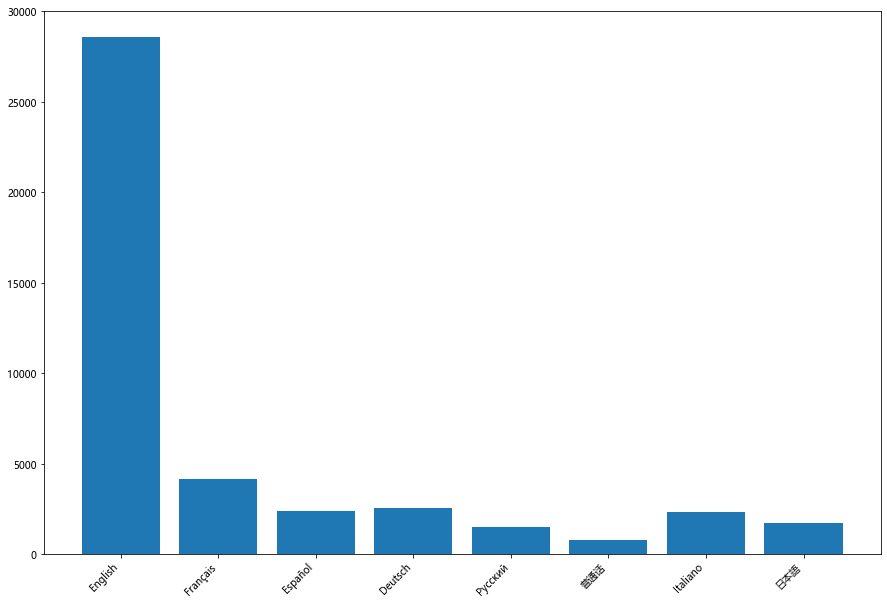

In [80]:
import matplotlib
matplotlib.rc("font", family='Microsoft YaHei')

fig, ax = plt.subplots(figsize=(15,10))
ax.bar(lang.keys(), lang.values())
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.show()

In [81]:
for l in lang.keys():
    temp_df = movies['spoken_languages'].apply(lambda x: 1 if l in x else 0)
    movies[f'lang_{l}'] = temp_df
movies = movies.copy()
movies.head()

,adult,belongs_to_collection,budget,id,runtime,spoken_languages,status,title,vote_average,vote_count,is_Animation,is_Comedy,is_Family,is_Adventure,is_Fantasy,is_Romance,is_Drama,is_Action,is_Crime,is_Thriller,is_Horror,is_History,is_Science Fiction,is_Mystery,is_War,is_Foreign,is_Music,is_Documentary,is_Western,is_TV Movie,company_Pixar Animation Studios,company_TriStar Pictures,company_Warner Bros.,company_Twentieth Century Fox Film Corporation,company_Touchstone Pictures,company_Regency Enterprises,company_Paramount Pictures,company_Walt Disney Pictures,company_Universal Pictures,company_United Artists,company_Columbia Pictures,company_Castle Rock Entertainment,company_Amblin Entertainment,company_Hollywood Pictures,company_Metro-Goldwyn-Mayer (MGM),company_Columbia Pictures Corporation,company_Miramax Films,company_Morgan Creek Productions,company_New Regency Pictures,company_Silver Pictures,company_Canal+,company_New Line Cinema,company_BBC Films,company_France 3 Cinéma,company_Eurimages,company_Televisión Española (TVE),company_Canal+ España,company_Centre National de la Cinématographie (CNC),company_StudioCanal,company_PolyGram Filmed Entertainment,company_Working Title Films,company_The Rank Organisation,company_TF1 Films Production,company_Dimension Films,company_Zweites Deutsches Fernsehen (ZDF),company_Channel Four Films,company_British Broadcasting Corporation (BBC),company_Westdeutscher Rundfunk (WDR),company_Téléfilm Canada,company_France 2 Cinéma,company_Fine Line Features,company_Fox Searchlight Pictures,company_BBC,company_Imagine Entertainment,company_Davis Entertainment,company_Home Box Office (HBO),company_Gaumont,company_Orion Pictures,company_HBO Films,company_Shaw Brothers,company_Nordisk Film,company_Svensk Filmindustri (SF),company_Walt Disney Productions,company_RKO Radio Pictures,company_Fox 2000 Pictures,company_Lakeshore Entertainment,company_Village Roadshow Pictures,company_Film4,company_TLA Releasing,company_Toho Company,company_Summit Entertainment,company_Lionsgate,company_Constantin Film Produktion,company_Mosfilm,company_Universal International Pictures (UI),company_New World Pictures,company_American International Pictures (AIP),company_M6 Films,company_Hallmark Entertainment,company_DreamWorks SKG,company_Lions Gate Films,company_Fox Film Corporation,company_Pathé,company_Nu Image Films,company_Millennium Films,company_Focus Features,company_Hammer Film Productions,company_DC Comics,company_Screen Gems,company_Warner Bros. Animation,company_Monogram Pictures,company_First National Pictures,company_Daiei Studios,company_Zentropa Entertainments,company_Arte France Cinéma,company_Film i Väst,company_EuropaCorp,company_UK Film Council,company_CJ Entertainment,company_Wild Bunch,company_Shôchiku Eiga,company_Nikkatsu,company_Lenfilm,company_Rai Cinema,company_CinéCinéma,company_The Weinstein Company,company_Dune Entertainment,company_Relativity Media,company_Blumhouse Productions,company_The Asylum,company_Ciné+,country_United States of America,country_Germany,country_United Kingdom,country_France,country_Italy,country_Spain,country_China,country_Australia,country_South Africa,country_Canada,country_Switzerland,country_Belgium,country_Japan,country_Iran,country_Netherlands,country_Hong Kong,country_Ireland,country_Croatia,country_Russia,country_Austria,country_Taiwan,country_New Zealand,country_Mexico,country_Poland,country_Peru,country_Cuba,country_Denmark,country_Portugal,country_Finland,country_Sweden,country_Argentina,country_Tunisia,country_Iceland,country_South Korea,country_Brazil,country_Hungary,country_Philippines,country_Czech Republic,country_Bulgaria,country_Chile,country_Norway,country_India,country_Kazakhstan,country_Luxembourg,country_Ukraine,country_Israel,country_Turkey,country_Greece,country_Morocco,country_Romania,country_Serbia,country_Thailand,country_Colombia,country_Uruguay,country_Soviet Union,country_Singapore,country_Slovakia,country_Venezuela,country_Lithuania,country_

In [82]:
movies.drop('spoken_languages', axis='columns', inplace=True)

Проверка, какие есть статусы фильмов

In [83]:
movies['status'].value_counts()

Released           44109
Rumored              223
Post Production       96
In Production         20
Planned               15
Canceled               2
Name: status, dtype: int64

In [84]:
movies = movies[movies['status']=='Released']
movies.drop('status', axis='columns', inplace=True)

Проверка на пустые значения в времени фильма

In [85]:
movies['runtime'].isnull().sum()

249

In [86]:
movies['runtime'] = movies['runtime'].fillna(value=0)

In [87]:
movies.head()

,adult,belongs_to_collection,budget,id,runtime,title,vote_average,vote_count,is_Animation,is_Comedy,is_Family,is_Adventure,is_Fantasy,is_Romance,is_Drama,is_Action,is_Crime,is_Thriller,is_Horror,is_History,is_Science Fiction,is_Mystery,is_War,is_Foreign,is_Music,is_Documentary,is_Western,is_TV Movie,company_Pixar Animation Studios,company_TriStar Pictures,company_Warner Bros.,company_Twentieth Century Fox Film Corporation,company_Touchstone Pictures,company_Regency Enterprises,company_Paramount Pictures,company_Walt Disney Pictures,company_Universal Pictures,company_United Artists,company_Columbia Pictures,company_Castle Rock Entertainment,company_Amblin Entertainment,company_Hollywood Pictures,company_Metro-Goldwyn-Mayer (MGM),company_Columbia Pictures Corporation,company_Miramax Films,company_Morgan Creek Productions,company_New Regency Pictures,company_Silver Pictures,company_Canal+,company_New Line Cinema,company_BBC Films,company_France 3 Cinéma,company_Eurimages,company_Televisión Española (TVE),company_Canal+ España,company_Centre National de la Cinématographie (CNC),company_StudioCanal,company_PolyGram Filmed Entertainment,company_Working Title Films,company_The Rank Organisation,company_TF1 Films Production,company_Dimension Films,company_Zweites Deutsches Fernsehen (ZDF),company_Channel Four Films,company_British Broadcasting Corporation (BBC),company_Westdeutscher Rundfunk (WDR),company_Téléfilm Canada,company_France 2 Cinéma,company_Fine Line Features,company_Fox Searchlight Pictures,company_BBC,company_Imagine Entertainment,company_Davis Entertainment,company_Home Box Office (HBO),company_Gaumont,company_Orion Pictures,company_HBO Films,company_Shaw Brothers,company_Nordisk Film,company_Svensk Filmindustri (SF),company_Walt Disney Productions,company_RKO Radio Pictures,company_Fox 2000 Pictures,company_Lakeshore Entertainment,company_Village Roadshow Pictures,company_Film4,company_TLA Releasing,company_Toho Company,company_Summit Entertainment,company_Lionsgate,company_Constantin Film Produktion,company_Mosfilm,company_Universal International Pictures (UI),company_New World Pictures,company_American International Pictures (AIP),company_M6 Films,company_Hallmark Entertainment,company_DreamWorks SKG,company_Lions Gate Films,company_Fox Film Corporation,company_Pathé,company_Nu Image Films,company_Millennium Films,company_Focus Features,company_Hammer Film Productions,company_DC Comics,company_Screen Gems,company_Warner Bros. Animation,company_Monogram Pictures,company_First National Pictures,company_Daiei Studios,company_Zentropa Entertainments,company_Arte France Cinéma,company_Film i Väst,company_EuropaCorp,company_UK Film Council,company_CJ Entertainment,company_Wild Bunch,company_Shôchiku Eiga,company_Nikkatsu,company_Lenfilm,company_Rai Cinema,company_CinéCinéma,company_The Weinstein Company,company_Dune Entertainment,company_Relativity Media,company_Blumhouse Productions,company_The Asylum,company_Ciné+,country_United States of America,country_Germany,country_United Kingdom,country_France,country_Italy,country_Spain,country_China,country_Australia,country_South Africa,country_Canada,country_Switzerland,country_Belgium,country_Japan,country_Iran,country_Netherlands,country_Hong Kong,country_Ireland,country_Croatia,country_Russia,country_Austria,country_Taiwan,country_New Zealand,country_Mexico,country_Poland,country_Peru,country_Cuba,country_Denmark,country_Portugal,country_Finland,country_Sweden,country_Argentina,country_Tunisia,country_Iceland,country_South Korea,country_Brazil,country_Hungary,country_Philippines,country_Czech Republic,country_Bulgaria,country_Chile,country_Norway,country_India,country_Kazakhstan,country_Luxembourg,country_Ukraine,country_Israel,country_Turkey,country_Greece,country_Morocco,country_Romania,country_Serbia,country_Thailand,country_Colombia,country_Uruguay,country_Soviet Union,country_Singapore,country_Slovakia,country_Venezuela,country_Lithuania,country_Estonia,country_United A

In [88]:
#название не нужно
movies.drop('title', axis='columns', inplace=True)

Оставим только те фильмы, у которых больше 100 отзывов

In [89]:
movies = movies[movies['vote_count'] > 100]

Исправим типы данных budget и id

In [90]:
movies.dtypes

adult                      int64
belongs_to_collection      int64
budget                    object
id                        object
runtime                  float64
                          ...   
lang_Deutsch               int64
lang_Pусский               int64
lang_普通话                   int64
lang_Italiano              int64
lang_日本語                   int64
Length: 197, dtype: object

In [91]:
movies['budget'] = movies['budget'].astype(int)

In [92]:
movies['id'] = movies['id'].astype(int)

### Построим матрицу зависимостей таблиц между собой

In [93]:
movies = movies.set_index('id')
movies.drop('vote_count', axis='columns', inplace=True)
col = list(movies.columns)
col.remove('vote_average')
col.append('vote_average')
movies = movies.reindex(columns=col)
movies.head()

,adult,belongs_to_collection,budget,runtime,is_Animation,is_Comedy,is_Family,is_Adventure,is_Fantasy,is_Romance,is_Drama,is_Action,is_Crime,is_Thriller,is_Horror,is_History,is_Science Fiction,is_Mystery,is_War,is_Foreign,is_Music,is_Documentary,is_Western,is_TV Movie,company_Pixar Animation Studios,company_TriStar Pictures,company_Warner Bros.,company_Twentieth Century Fox Film Corporation,company_Touchstone Pictures,company_Regency Enterprises,company_Paramount Pictures,company_Walt Disney Pictures,company_Universal Pictures,company_United Artists,company_Columbia Pictures,company_Castle Rock Entertainment,company_Amblin Entertainment,company_Hollywood Pictures,company_Metro-Goldwyn-Mayer (MGM),company_Columbia Pictures Corporation,company_Miramax Films,company_Morgan Creek Productions,company_New Regency Pictures,company_Silver Pictures,company_Canal+,company_New Line Cinema,company_BBC Films,company_France 3 Cinéma,company_Eurimages,company_Televisión Española (TVE),company_Canal+ España,company_Centre National de la Cinématographie (CNC),company_StudioCanal,company_PolyGram Filmed Entertainment,company_Working Title Films,company_The Rank Organisation,company_TF1 Films Production,company_Dimension Films,company_Zweites Deutsches Fernsehen (ZDF),company_Channel Four Films,company_British Broadcasting Corporation (BBC),company_Westdeutscher Rundfunk (WDR),company_Téléfilm Canada,company_France 2 Cinéma,company_Fine Line Features,company_Fox Searchlight Pictures,company_BBC,company_Imagine Entertainment,company_Davis Entertainment,company_Home Box Office (HBO),company_Gaumont,company_Orion Pictures,company_HBO Films,company_Shaw Brothers,company_Nordisk Film,company_Svensk Filmindustri (SF),company_Walt Disney Productions,company_RKO Radio Pictures,company_Fox 2000 Pictures,company_Lakeshore Entertainment,company_Village Roadshow Pictures,company_Film4,company_TLA Releasing,company_Toho Company,company_Summit Entertainment,company_Lionsgate,company_Constantin Film Produktion,company_Mosfilm,company_Universal International Pictures (UI),company_New World Pictures,company_American International Pictures (AIP),company_M6 Films,company_Hallmark Entertainment,company_DreamWorks SKG,company_Lions Gate Films,company_Fox Film Corporation,company_Pathé,company_Nu Image Films,company_Millennium Films,company_Focus Features,company_Hammer Film Productions,company_DC Comics,company_Screen Gems,company_Warner Bros. Animation,company_Monogram Pictures,company_First National Pictures,company_Daiei Studios,company_Zentropa Entertainments,company_Arte France Cinéma,company_Film i Väst,company_EuropaCorp,company_UK Film Council,company_CJ Entertainment,company_Wild Bunch,company_Shôchiku Eiga,company_Nikkatsu,company_Lenfilm,company_Rai Cinema,company_CinéCinéma,company_The Weinstein Company,company_Dune Entertainment,company_Relativity Media,company_Blumhouse Productions,company_The Asylum,company_Ciné+,country_United States of America,country_Germany,country_United Kingdom,country_France,country_Italy,country_Spain,country_China,country_Australia,country_South Africa,country_Canada,country_Switzerland,country_Belgium,country_Japan,country_Iran,country_Netherlands,country_Hong Kong,country_Ireland,country_Croatia,country_Russia,country_Austria,country_Taiwan,country_New Zealand,country_Mexico,country_Poland,country_Peru,country_Cuba,country_Denmark,country_Portugal,country_Finland,country_Sweden,country_Argentina,country_Tunisia,country_Iceland,country_South Korea,country_Brazil,country_Hungary,country_Philippines,country_Czech Republic,country_Bulgaria,country_Chile,country_Norway,country_India,country_Kazakhstan,country_Luxembourg,country_Ukraine,country_Israel,country_Turkey,country_Greece,country_Morocco,country_Romania,country_Serbia,country_Thailand,country_Colombia,country_Uruguay,country_Soviet Union,country_Singapore,country_Slovakia,country_Venezuela,country_Lithuania,country_Estonia,country_United Arab Emirates,lang_English,lang_Fr

In [94]:
movies[list(movies.columns)[:4] + ['vote_average']].corr()

,adult,belongs_to_collection,budget,runtime,vote_average
adult,NaN,NaN,NaN,NaN,NaN
belongs_to_collection,NaN,1.000000,0.164734,-0.074940,-0.125908
budget,NaN,0.164734,1.000000,0.254176,-0.089393
runtime,NaN,-0.074940,0.254176,1.000000,0.244150
vote_average,NaN,-0.125908,-0.089393,0.244150,1.000000


<AxesSubplot:>

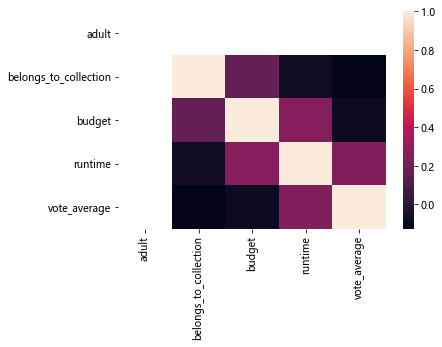

In [95]:
sns.heatmap(movies[list(movies.columns)[:4] + ['vote_average']].corr())

Можно заметить, что vote_average в какой-то степени зависит от начальных переменных
<br>Однако adult выдаёт значения NaN на корреляционной матрице, значит его не стоит учитывать при обучении модели

# Обучение модели машинного обучения

In [96]:
X = movies.drop(['vote_average', 'adult'], axis='columns')
y = movies['vote_average']

In [97]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.1)

In [98]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
print('RMSE train ' + str(np.sqrt(mean_squared_error(y_train, reg.predict(X_train)))))
print('RMSE test ' + str(np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))))

RMSE train 0.6920353363683399
RMSE test 0.6784859611554045


In [99]:
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                             max_depth = 3,
                             learning_rate = 0.1,
                             n_estimators = 100,
                             booster = 'gbtree',
                             gamma = 0.01, 
                             max_delta_step = 5, 
                             reg_alpha = 0.1, 
                             reg_lambda = 1)

model_xgb.fit(X_train, y_train)

print('RMSE train ' + str(np.sqrt(mean_squared_error(y_train, model_xgb.predict(X_train)))))
print('RMSE test ' + str(np.sqrt(mean_squared_error(y_test, model_xgb.predict(X_test)))))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


RMSE train 0.6458091616256468
RMSE test 0.625368302306133


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


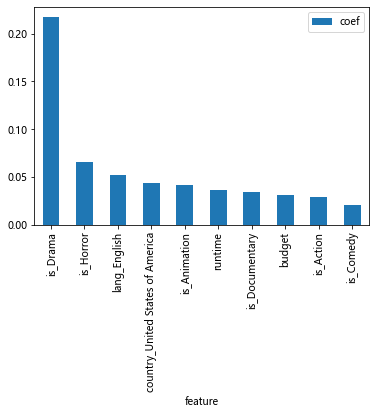

In [100]:
xgb_regr_coef = pd.DataFrame(columns = ['feature', 'coef'])
xgb_regr_coef['feature'] = np.array(X.columns)
xgb_regr_coef['coef'] = abs(model_xgb.feature_importances_)
xgb_regr_coef = xgb_regr_coef.set_index('feature')
xgb_regr_coef.sort_values(by = ['coef'], ascending = False).head(10).plot.bar()
plt.show()

Модель XGBoost Regressor очевидно лучше справляется с задачей
<br>Давайте посмотрим на то, насколько сильно она может ошибаться

In [101]:
prediction = model_xgb.predict(X)
np.array(prediction)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


array([6.7830973, 6.003788 , 6.1595964, ..., 5.996403 , 6.922658 ,
       6.0272202], dtype=float32)

In [102]:
target = np.array(y)
target

array([7.7, 6.9, 5.7, ..., 4. , 8.3, 5.2])

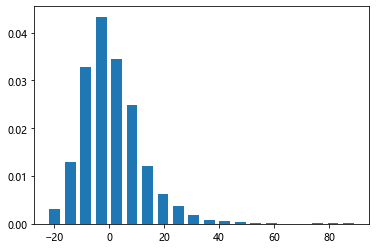

In [103]:
miss = (prediction - target)/target * 100
plt.hist(miss, bins=20, rwidth=0.7, density=True)
plt.show()

In [104]:
len(miss[abs(miss) <= 20])/len(miss)

0.9377918612408273

93.8% рейтингов фильмов были предсказаны с точностью 20%